# AI Assistant with Supervisors Demo

Welcome to the AI Assistant with Supervisors demo! This notebook is designed to demonstrate how to use **Entropy Labs Supervisors** to supervise tool executions within an AI assistant. We'll walk through the code, explain key components, and show how to run the assistant.

## Table of Contents

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Supervisors](#Supervisors)
   - [The `supervise()` Decorator](#The-supervise%28%29-Decorator)
   - [Custom Supervisor: `check_email_address_supervisor`](#Custom-Supervisor%3A-check_email_address_supervisor)
   - [Built-in Supervisors: `llm_supervisor` and `human_supervisor`](#Built-in-Supervisors%3A-llm_supervisor-and-human_supervisor)
4. [Tools](#Tools)
   - [`internet_search`](#internet_search)
   - [`send_email`](#send_email)
   - [`create_calendar_event`](#create_calendar_event)
   - [`book_flight`](#book_flight)
5. [Assistant Agent](#Assistant-Agent)
   - [Creating OpenAI Tools](#Creating-OpenAI-Tools)
   - [Chat Function with OpenAI](#Chat-Function-with-OpenAI)
   - [Executing Tool Calls](#Executing-Tool-Calls)
   - [Updating Messages](#Updating-Messages)
   - [Starting the Chatbot](#Starting-the-Chatbot)
6. [Running the Assistant](#Running-the-Assistant)
7. [Conclusion](#Conclusion)

## Introduction

In this demo, we'll create an AI assistant that can perform tasks like searching the internet, sending emails, creating calendar events, and booking flights. We'll use **Entropy Labs Supervisors** to supervise these tool executions, ensuring they comply with specified policies or require human approval when necessary.

**Important:** Before running the notebook, make sure that the Entropy Labs backend is running. You can start it with `docker compose up` in the root directory.

## Setup
First let's install the necessary libraries.

In [1]:
%pip install entropy-labs inspect-ai openai duckduckgo-search bs4 ipywidgets

Note: you may need to restart the kernel to use updated packages.




We start with importing the necessary libraries and initializing the OpenAI client.

In [1]:
import json
import inspect
from typing import Callable, Any, List, Dict, get_type_hints, Optional
from enum import Enum
from uuid import UUID

import requests
from bs4 import BeautifulSoup
from openai import OpenAI
from openai.types.chat import ChatCompletionMessage
from duckduckgo_search import DDGS

from entropy_labs.supervision import supervise
from entropy_labs.api import register_project, create_run, register_task, submit_run_status, submit_run_result, Status
from entropy_labs.supervision.supervisors import human_supervisor, llm_supervisor, Supervisor
from entropy_labs.supervision.config import (
    SupervisionDecision,
    SupervisionDecisionType,
    SupervisionContext,
    get_supervision_context,
)
# Initialize the OpenAI client
client = OpenAI()

## Supervisors

In Entropy Labs, **supervisors** are functions that can approve, modify, or escalate tool calls based on certain policies or checks.

### The `supervise()` Decorator

The `supervise()` decorator is used to wrap tool functions with supervisor logic.

```python
def supervise(supervision_functions: Optional[List[List[Supervisor]]] = None, **kwargs):
    """
    Decorator to supervise a function call with the specified supervision functions.

    Args:
        supervision_functions (Optional[List[List[Supervisor]]]): Nested list of supervisors.
    """
    def decorator(func: Callable) -> Supervisor:
        def wrapper(*args, **kwargs) -> SupervisionDecision:
            # Supervision logic here...
            return func(*args, **kwargs)
        return wrapper
    return decorator
```

### Custom Supervisor: `check_email_address_supervisor`

Entropy labs provide multiple configurable supervisors, but you can also define your own specific to your application. Here we define a custom supervisor to check if an email address is in an email whitelist before sending an email.

In [3]:
# Constants
ENTROPY_LABS_EMAIL = "devs@entropy-labs.ai"

def check_email_address_supervisor(whitelisted_emails: List[str]) -> Supervisor:
    """
    Factory function that creates a supervisor function to check if the email address
    is in the whitelist.

    Args:
        whitelisted_emails (List[str]): List of whitelisted email addresses.

    Returns:
        Supervisor: A supervisor function checking the email address against the whitelist.
    """
    def supervisor(
        func: Callable,
        supervision_context: SupervisionContext,
        tool_kwargs: Dict[str, Any],
        **kwargs
    ) -> SupervisionDecision:
        """
        Checks if the email address is in the whitelist.

        Args:
            func (Callable): The function being supervised.
            supervision_context (SupervisionContext): Context of the supervision.
            tool_kwargs (Dict[str, Any]): Keyword arguments for the tool function.

        Returns:
            SupervisionDecision: The decision to approve or escalate the tool call.
        """
        to_email = tool_kwargs.get('to')
        if to_email is None:
            return SupervisionDecision(
                decision=SupervisionDecisionType.ESCALATE,
                explanation="No email address provided."
            )
        if to_email in whitelisted_emails:
            return SupervisionDecision(
                decision=SupervisionDecisionType.APPROVE,
                explanation=f"The email address '{to_email}' is allowed."
            )
        else:
            return SupervisionDecision(
                decision=SupervisionDecisionType.ESCALATE,
                explanation=(
                    f"The email address '{to_email}' is not in the whitelist. "
                    f"Whitelisted emails: {whitelisted_emails}"
                )
            )
    supervisor.__name__ = check_email_address_supervisor.__name__
    supervisor.supervisor_attributes = {"whitelisted_emails": whitelisted_emails}
    return supervisor

### Built-in Supervisors: `llm_supervisor` and `human_supervisor`

- **`llm_supervisor`**: Uses an LLM to check if the tool call complies with specified policies.
- **`human_supervisor`**: Requires human approval for the tool call.

```python
def llm_supervisor(instructions: str, **kwargs) -> Supervisor:
    """
    Supervisor that uses an LLM to make a decision based on the provided instructions.

    Args:
        instructions (str): Instructions for the LLM.
        **kwargs: Additional keyword arguments.
    """
    # Implementation...

def human_supervisor(**kwargs) -> Supervisor:
    """
    Supervisor that requires human approval.

    Returns:
        Supervisor: Supervisor function that always escalates for human approval.
    """
    # Implementation...
```

## Tools

Our assistant will have several tools at its disposal, each supervised to ensure compliance with policies.

### `internet_search`

Searches the internet using DuckDuckGo and retrieves content from the results. We use the `supervise()` decorator without any supervision functions to allow the LLM to call the tool freely.

In [4]:
@supervise()
def internet_search(query: str, max_results: int = 3) -> str:
    """
    Search the internet for information using DuckDuckGo and fetch content from the first few links.

    Parameters:
        query (str): Query to search the internet with.
        max_results (int): Maximum number of results to fetch content from.

    Returns:
        str: Concatenated content from the search results.
    """
    # Define search settings
    region = "wt-wt"  # Worldwide
    safesearch = "moderate"  # Safe search level

    try:
        with DDGS() as ddgs:
            results = []
            # Perform the search
            search_results = ddgs.text(
                query,
                region=region,
                safesearch=safesearch,
                max_results=max_results
            )

            for r in search_results:
                result = {
                    'title': r['title'],
                    'href': r['href'],
                    'snippet': r['body'],
                    'content': ''
                }
                try:
                    # Fetch content from the link
                    response = requests.get(r['href'], timeout=5)
                    soup = BeautifulSoup(response.content, 'html.parser')
                    # Extract text content from the web page
                    paragraphs = soup.find_all('p')
                    text_content = ' '.join([p.get_text() for p in paragraphs])
                    result['content'] = text_content
                except Exception as e:
                    print(f"Error fetching content from {r['href']}: {str(e)}")
                results.append(result)

            # Combine content from all results
            combined_content = '\n'.join([res['content'] for res in results if res['content']])
            return combined_content if combined_content else f"No content found for '{query}'."
    except Exception as e:
        print(f"Error performing search: {str(e)}")
        return f"Error performing search for '{query}'."

Registered pending supervised function 'internet_search'


### `send_email`

Sends an email, supervised to ensure the recipient's email is allowed and the email content complies with policies. For this example, we use two supervisor chains that can be run in parallel:

1. Chain 1 - Check if the recipient's email is in the whitelist
2. Chain 2 - Check if the email content complies with the email invitation policy and if not escalates to human approval

Both of these chains need to approve the tool call for it to be successful.

In [5]:
# Policies
EMAIL_INVITATION_POLICY = (
    "Ensure that the email invitation is clear, concise, and includes all necessary details about the event. "
    "Verify that the recipient's email address is correct given the previous messages."
)

In [6]:
@supervise(supervision_functions=[
    [check_email_address_supervisor(whitelisted_emails=[ENTROPY_LABS_EMAIL])],
    [llm_supervisor(instructions=EMAIL_INVITATION_POLICY), human_supervisor()]
])
def send_email(to: str, subject: str, body: str):
    """
    Send an email to the specified recipient.

    Parameters:
        to (str): Recipient's email address.
        subject (str): Subject of the email.
        body (str): Body content of the email.

    Returns:
        str: A message indicating the result of the email sending process.
    """
    # Mocking the email sending process
    return f"Email sent to {to} with subject '{subject}'"

Registered pending supervised function 'send_email'


### `create_calendar_event`

Creates a calendar event, supervised to ensure correct parameters given the previous messages.

In [7]:
CORRECT_TOOL_PARAMETERS_POLICY = (
    "Make sure that the tool parameters are correct given the previous messages. If incorrect, fix them."
)

In [8]:
@supervise(supervision_functions=[[llm_supervisor(instructions=CORRECT_TOOL_PARAMETERS_POLICY)]])
def create_calendar_event(title: str, start_time: str, end_time: str):
    """
    Create a calendar event.

    Parameters:
        title (str): Title of the event.
        start_time (str): Start time of the event.
        end_time (str): End time of the event.

    Returns:
        str: A message indicating the result of the calendar event creation process.
    """
    # Mocking the calendar event creation process
    return f"Event '{title}' created from {start_time} to {end_time}"

Registered pending supervised function 'create_calendar_event'


### `book_flight`

Books a flight ticket, requiring human supervision always.

In [9]:
@supervise(supervision_functions=[[human_supervisor()]])
def book_flight(departure_city: str, arrival_city: str, datetime: str, maximum_price: float):
    """
    Book a flight ticket.

    Parameters:
        departure_city (str): Departure city.
        arrival_city (str): Arrival city.
        datetime (str): Departure date and time.
        maximum_price (float): Maximum acceptable price for the flight.

    Returns:
        str: A message indicating the result of the flight booking process.
    """
    # Mocking the flight booking process
    return f"Flight booked from {departure_city} to {arrival_city} on {datetime}."

Registered pending supervised function 'book_flight'


## Assistant Agent

Let's build the assistant agent that will interact with the user, utilize the tools, and handle OpenAI responses.

### Creating OpenAI Tools

We need to create tool definitions that conform to OpenAI's expected schema.

In [10]:
def create_openai_tool(func: Callable) -> dict:
    """
    Create an OpenAI tool definition from a function, conforming to OpenAI's expected schema.

    Parameters:
        func (Callable): The function to create a tool definition for.

    Returns:
        dict: A dictionary representing the tool definition.
    """
    signature = inspect.signature(func)
    type_hints = get_type_hints(func)

    def python_type_to_json_type(py_type: Any) -> str:
        """
        Convert a Python type to a JSON schema type.

        Parameters:
            py_type (Any): The Python type to convert.

        Returns:
            str: The corresponding JSON type as a string.
        """
        if py_type == str:
            return "string"
        elif py_type == int:
            return "integer"
        elif py_type == float:
            return "number"
        elif py_type == bool:
            return "boolean"
        elif py_type == dict:
            return "object"
        elif py_type == list:
            return "array"
        elif isinstance(py_type, type) and issubclass(py_type, Enum):
            return "string"
        else:
            return "string"  # Default to string for unsupported types

    parameters: Dict[str, Any] = {
        "type": "object",
        "properties": {},
        "additionalProperties": False  # Ensure no additional properties are allowed
    }

    required_params = []

    for param_name, param in signature.parameters.items():
        param_type = type_hints.get(param_name, str)
        param_schema = {
            "type": python_type_to_json_type(param_type),
            "description": param_name
        }

        # If the parameter has an Enum type, add the enum options
        if isinstance(param_type, type) and issubclass(param_type, Enum):
            param_schema["enum"] = [e.value for e in param_type]

        parameters["properties"][param_name] = param_schema

        # Include all parameters in required when strict is True
        required_params.append(param_name)

    parameters["required"] = required_params

    # Build the function definition
    return {
        "type": "function",
        "function": {
            "name": func.__name__,
            "description": func.__doc__ or "",
            "parameters": parameters,
            "strict": True
        }
    }

### Chat Function with OpenAI

Handles interaction with the OpenAI GPT model.

In [11]:
def chat_with_openai(messages: List[Dict], tools: List[Callable]):
    """
    Interact with the OpenAI GPT model.

    Parameters:
        messages (List[Dict]): The conversation history.
        tools (List[Callable]): The list of tools available to the assistant.

    Returns:
        The completion response from the OpenAI API.
    """
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        tools=tools,
        parallel_tool_calls=False
    )
    return completion

### Executing Tool Calls

Executes the tool calls as decided by the assistant.

In [12]:
def execute_tool_call(tool_call, tools):
    """
    Execute a tool call as decided by the assistant.

    Parameters:
        tool_call: The tool call object from the assistant's response.
        tools (List[Callable]): The list of available tool functions.

    Returns:
        The result of the tool function execution.
    """
    function_name = tool_call.function.name
    arguments = json.loads(tool_call.function.arguments)
    print(f"Executing tool call: {function_name} with arguments: {arguments}")

    # Map function names to actual functions
    for tool in tools:
        if tool.__name__ == function_name:
            result = tool(**arguments)
            print(f"Tool call {function_name} result: {result}")
            return result

    print("Function not found.")
    return "Function not found."

### Updating Messages

Updates the conversation messages and the supervision context.

In [13]:
def update_messages(
    messages: List[Dict],
    new_message: Dict[str, Any] | ChatCompletionMessage,
    run_id: UUID
) -> List[Dict]:
    """
    Update the conversation messages and supervision context.

    Parameters:
        messages (List[Dict]): The current list of messages.
        new_message (Dict[str, Any] | ChatCompletionMessage): The new message to add.
        run_id (UUID): The ID of the current run.

    Returns:
        List[Dict]: The updated list of messages.
    """
    supervision_context = get_supervision_context(run_id)
    if isinstance(new_message, ChatCompletionMessage):
        new_message = new_message.to_dict()
    supervision_context.update_messages(messages + [new_message])
    return messages + [new_message]

### Starting the Chatbot

The main loop that starts the chatbot and handles user interaction.

In [14]:
def in_jupyter_notebook():
    try:
        from IPython import get_ipython
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        else:
            return False  # Other type (likely standard Python interpreter)
    except NameError:
        return False      # Probably standard Python interpreter


def start_chatbot(
    start_prompt: str,
    tools: List[Callable],
    run_id: UUID,
):
    """
    Start the chatbot interaction, working both in Jupyter Notebook and standard Python script.

    Parameters:
        start_prompt (str): The initial prompt for the assistant.
        tools (List[Callable]): The list of available tool functions.
        run_id (UUID): The ID of the current run.

    Returns:
        None
    """
    # Detect environment
    is_jupyter = in_jupyter_notebook()

    if is_jupyter:
        # Import Jupyter-specific modules inside the conditional block
        import ipywidgets as widgets
        from IPython.display import display

        # Create the output and input widgets
        output_widget = widgets.Output(layout={'border': '1px solid black'})
        input_widget = widgets.Text(
            value='',
            placeholder='Type your message here...',
            description='You:',
            disabled=False,
            continuous_update=False  # Update value only when Enter is pressed
        )

        # Display the widgets
        display(output_widget)
        display(input_widget)

        # Clear the output widget to avoid duplicate messages
        output_widget.clear_output()
    else:
        output_widget = None
        input_widget = None

    # Initialize conversation messages
    messages = [{"role": "system", "content": "You are a helpful assistant."}]

    # Create OpenAI tool definitions
    openai_tools = [create_openai_tool(func) for func in tools]

    waiting_for_user_input = False

    def process_assistant_response(assistant_message):
        nonlocal messages, waiting_for_user_input

        if assistant_message.content:
            if is_jupyter and output_widget:
                with output_widget:
                    print(f"Assistant: {assistant_message.content}\n")
            else:
                print(f"Assistant: {assistant_message.content}\n")

        # Check if the assistant is making a tool call
        if assistant_message.tool_calls:
            tool_call = assistant_message.tool_calls[0]

            # Execute the tool call
            result = execute_tool_call(tool_call, tools)

            tool_response = {
                "role": "tool",
                "content": json.dumps(result),
                "tool_call_id": tool_call.id
            }

            messages = update_messages(messages, tool_response, run_id)

            # Now get the assistant's response to the tool execution
            response = chat_with_openai(messages, openai_tools)
            assistant_message = response.choices[0].message
            messages = update_messages(messages, assistant_message, run_id)

            # Process the assistant's response recursively
            process_assistant_response(assistant_message)
        else:
            # Assistant is not making a tool call, wait for user input
            waiting_for_user_input = True

    # Start the conversation
    user_message = {"role": "user", "content": start_prompt}
    messages = update_messages(messages, user_message, run_id)
    if is_jupyter and output_widget:
        with output_widget:
            print(f"You: {start_prompt}\n")
    else:
        print(f"You: {start_prompt}\n")

    # Get assistant's initial response
    response = chat_with_openai(messages, openai_tools)
    assistant_message = response.choices[0].message
    messages = update_messages(messages, assistant_message, run_id)
    process_assistant_response(assistant_message)

    # Input handling
    if is_jupyter and input_widget:
        # Remove existing event handlers to prevent multiple triggers
        input_widget.unobserve_all()

        def handle_submit(change):
            nonlocal messages, waiting_for_user_input

            # Proceed only if value changed (Enter was pressed)
            if not waiting_for_user_input or not change['new']:
                return  # Ignore input if not waiting for user or empty input

            user_input = change['new']
            input_widget.value = ''  # Clear input box

            if user_input.lower() == 'exit':
                input_widget.disabled = True
                if output_widget:
                    with output_widget:
                        print("Goodbye! 👋")
                else:
                    print("Goodbye! 👋")
                return

            # Add user message to conversation
            user_message = {"role": "user", "content": user_input}
            messages = update_messages(messages, user_message, run_id)

            if output_widget:
                with output_widget:
                    print(f"You: {user_input}\n")
            else:
                print(f"You: {user_input}\n")

            waiting_for_user_input = False

            # Get assistant response
            response = chat_with_openai(messages, openai_tools)
            assistant_message = response.choices[0].message
            messages = update_messages(messages, assistant_message, run_id)

            process_assistant_response(assistant_message)

        # Register the event handler
        input_widget.observe(handle_submit, names='value')
    else:
        # Standard input/output loop
        while True:
            if waiting_for_user_input:
                user_input = input("You: ").strip()
                if user_input.lower() == 'exit':
                    print("Goodbye! 👋")
                    break
                if not user_input:
                    continue  # Ignore empty input

                # Add user message to conversation
                user_message = {"role": "user", "content": user_input}
                messages = update_messages(messages, user_message, run_id)

                print(f"You: {user_input}\n")
                waiting_for_user_input = False

                # Get assistant response
                response = chat_with_openai(messages, openai_tools)
                assistant_message = response.choices[0].message
                messages = update_messages(messages, assistant_message, run_id)

                process_assistant_response(assistant_message)
            else:
                # If the assistant is processing, wait until it's ready for user input
                pass
    submit_run_status(run_id=run_id, status=Status.COMPLETED)
    submit_run_result(run_id=run_id, result="passed")

## Running the Assistant

Finally, we set up the environment and start the assistant. You can now interact with the assistant by typing messages in the input box and see the supervisors in your web browser at: http://localhost:3000/.

In [15]:

# Define the initial prompt for the chatbot
start_prompt = (
    "Go and find the most interesting events happening in AI next week in San Francisco. "
    "Then create a calendar event for the most interesting one. When done, ask me email addresses "
    "where you should send invitations for that event. After the email is sent, book me a flight ticket "
    "from London to San Francisco to attend that event. Make sure that the flight price is less than 1000 GBP."
)

# List of tools available to the assistant
tools = [
    internet_search,
    send_email,
    create_calendar_event,
    book_flight
]

# Register project, task, and run with Entropy Labs
entropy_labs_backend_url = "http://localhost:8080"

# Entropy Labs backend needs to be running
project_id = register_project(
    project_name="Email Assistant",
    entropy_labs_backend_url=entropy_labs_backend_url
)
task_id = register_task(project_id=project_id, task_name="Email Assistant")
run_id = create_run(project_id=project_id, task_id=task_id, tools=tools)

# Start the chatbot
start_chatbot(start_prompt, tools, run_id)

Initialized supervised functions registry with pending functions.
Updated run ID for 'internet_search' to 1796faf8-ecc0-4c30-a6c0-354808a4b66b
Updated tool ID for 'internet_search' to e37bb8ca-aa1c-4dc0-9ef3-bfd48dcd633f
Tool 'internet_search' registered with ID: e37bb8ca-aa1c-4dc0-9ef3-bfd48dcd633f
Supervisor 'auto_approve_supervisor' registered with ID: 16a40e12-2425-4b01-9d56-a3a9e1a55894
Associating supervisors with tool 'internet_search' for run ID 1796faf8-ecc0-4c30-a6c0-354808a4b66b
Supervisors assigned to tool 'internet_search' for run ID 1796faf8-ecc0-4c30-a6c0-354808a4b66b
Updated run ID for 'send_email' to 1796faf8-ecc0-4c30-a6c0-354808a4b66b
Updated tool ID for 'send_email' to 17dc40cd-6f9b-4c5a-9bd0-ec0295a09122
Tool 'send_email' registered with ID: 17dc40cd-6f9b-4c5a-9bd0-ec0295a09122
Supervisor 'check_email_address_supervisor' registered with ID: 26a55790-352d-48ce-9c70-f44935b528d3
Supervisor 'llm_supervisor' registered with ID: 8f6c21bd-434d-48af-b3ad-ce74169f1d73
Supe

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

Text(value='', continuous_update=False, description='You:', placeholder='Type your message here...')

Executing tool call: internet_search with arguments: {'query': 'AI events in San Francisco next week', 'max_results': 3}

--- Supervision ---
Function Name: internet_search
Description: 
    Search the internet for information using DuckDuckGo and fetch content from the first few links.

    Parameters:
        query (str): Query to search the internet with.
        max_results (int): Maximum number of results to fetch content from.

    Returns:
        str: Concatenated content from the search results.
    
Arguments: (), dict_keys(['query', 'max_results'])
Tool request group created with ID: cb8fa12f-3f0f-44d3-b2bf-c6021535dcb9
Retrieved 1 supervisor chains from the API.
Created supervision request with ID: 39e8bf2f-2f00-464b-abad-dc44b1aa7d29
Supervisor decision: SupervisionDecisionType.APPROVE
Successfully submitted supervision result for supervision request ID: 39e8bf2f-2f00-464b-abad-dc44b1aa7d29
All decisions approved or modified.
Tool call internet_search result: Thu, Dec 12, 

In the web browser, you should see the supervisors in action at http://localhost:3000/.
1. Click on Projects
2. Click on the View Project button for "Email Assistant"
3. Open the Run Details for the latest run

You should now see run details with function calls, approvals, and escalations. If asking for booking a flight, you should see an approval request for the flight booking with a screen similar to this:

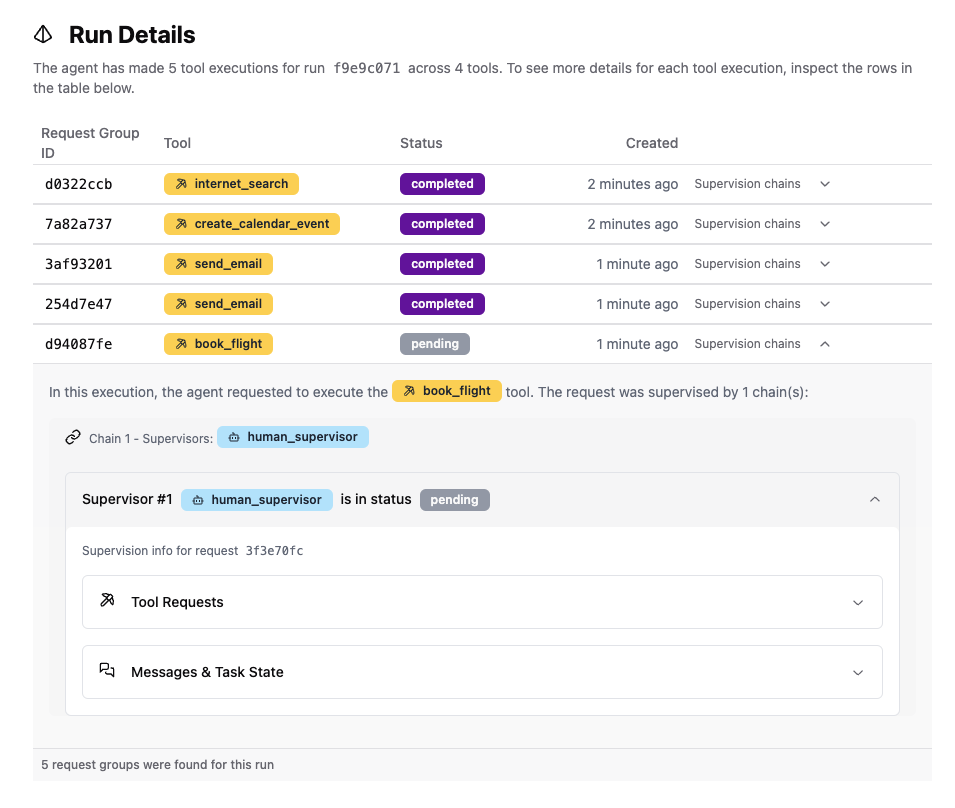


After clicking on `human_supervisor`, you should see a screen asking you to approve or reject the tool call:

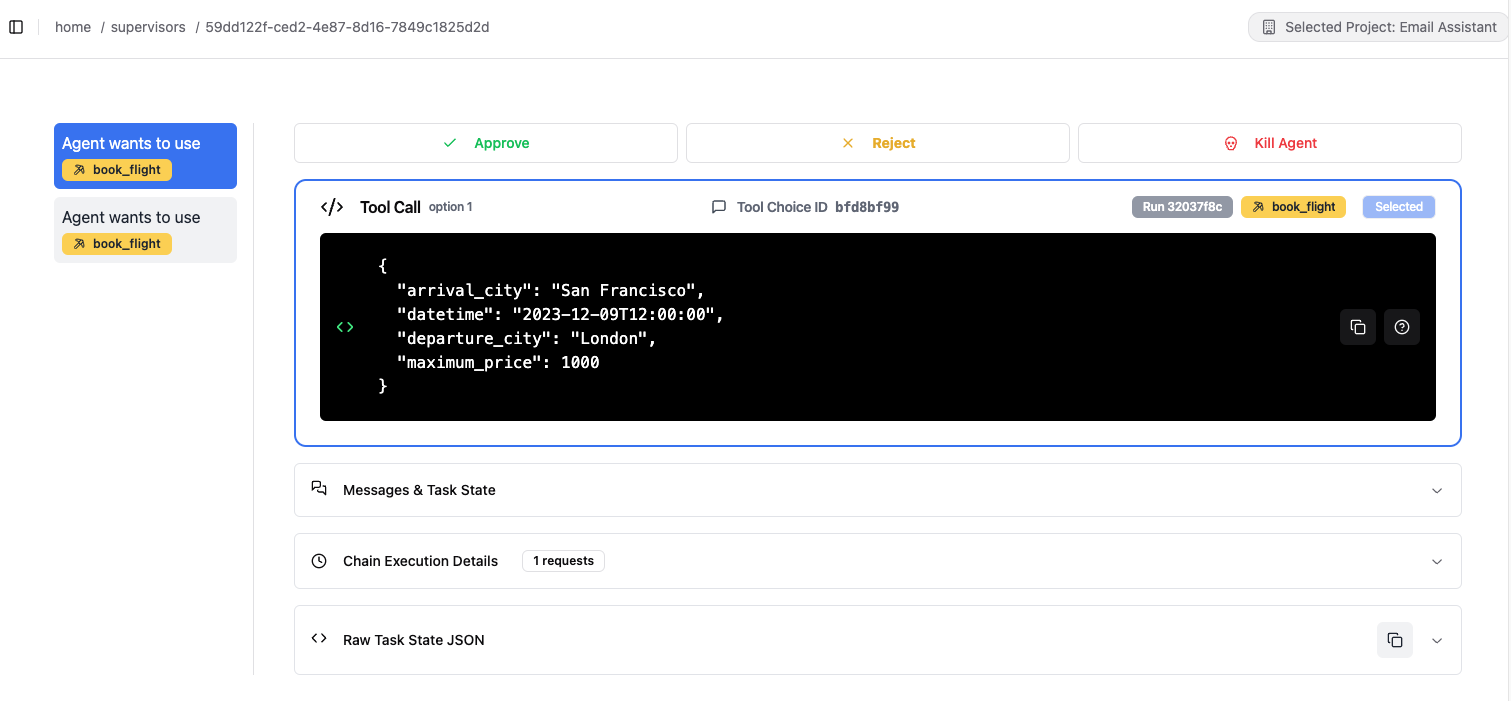

If you reject the tool call, the assistant will not execute the tool call and will continue with the execution asking for next instructions.

# Conclusion

In this notebook, we've demonstrated how to create basic AI assistant with calendar event creation, email sending, and flight booking with supervised tool executions using Entropy Labs Supervisors. By defining custom supervisors and utilizing built-in ones, we can ensure that tool calls conform to specified policies, enhancing the safety and reliability of AI assistants.